In [1]:
!nvidia-smi

Sat Nov 18 07:36:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# change working Directory
%cd /content/drive/MyDrive/vechile_tracking/

/content/drive/MyDrive/vechile_tracking


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content/drive/MyDrive/vechile_tracking


In [5]:
# show available file in directory
!ls

track_count_yolov8.ipynb  vechile_track_count_yolov8.ipynb  video.mp4


In [26]:
# Source
SOURCE_VIDEO = f"{HOME}/video.mp4"

In [7]:
# ultralytics model

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.212 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.9/78.2 GB disk)


## Install ByteTrack

[ByteTrack](https://github.com/ifzhang/ByteTrack) is great tracker but a bit poorly packaged. We encounter some challenges that require significant effort to integrate  yolo v8 seamlessly into our workflow.[YOLOv8](https://github.com/ultralytics/ultralytics).

In [8]:
# roboflow
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
!pip install -q loguru lap thop

from IPython import display
display.clear_output()

import sys
sys.path.append(f"{HOME}/ByteTrack")

import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [9]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass

@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Roboflow Supervision

In [10]:
!pip install supervision==0.1.0

from IPython import display
display.clear_output()

import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [11]:
# import supervision library
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Tracking utils


In [12]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [13]:
# settings
MODEL = "yolov8x.pt"

In [18]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


## Predict and annotate single frame

In [16]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8x.pt conf=0.5 source={SOURCE_VIDEO}

/content/drive/MyDrive/vechile_tracking
Ultralytics YOLOv8.0.212 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs

video 1/1 (1/539) /content/drive/MyDrive/vechile_tracking/video.mp4: 640x384 1 car, 134.0ms
video 1/1 (2/539) /content/drive/MyDrive/vechile_tracking/video.mp4: 640x384 2 cars, 52.0ms
video 1/1 (3/539) /content/drive/MyDrive/vechile_tracking/video.mp4: 640x384 1 car, 51.9ms
video 1/1 (4/539) /content/drive/MyDrive/vechile_tracking/video.mp4: 640x384 2 cars, 51.9ms
video 1/1 (5/539) /content/drive/MyDrive/vechile_tracking/video.mp4: 640x384 2 cars, 31.6ms
video 1/1 (6/539) /content/drive/MyDrive/vechile_tracking/video.mp4: 640x384 2 cars, 31.5ms
video 1/1 (7/539) /content/drive/MyDrive/vechile_tracking/video.mp4: 640x384 1 car, 31.2ms
video 1/1 (8/539) /content/drive/MyDrive/vechile_tracking/video.mp4: 640x384 1 car, 32.5ms
video 1/1 (9/539) /content/drive/MyDrive/vechile_track

In [19]:
model.model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [20]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]


0: 640x384 2 cars, 1 traffic light, 144.9ms
Speed: 4.2ms preprocess, 144.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)


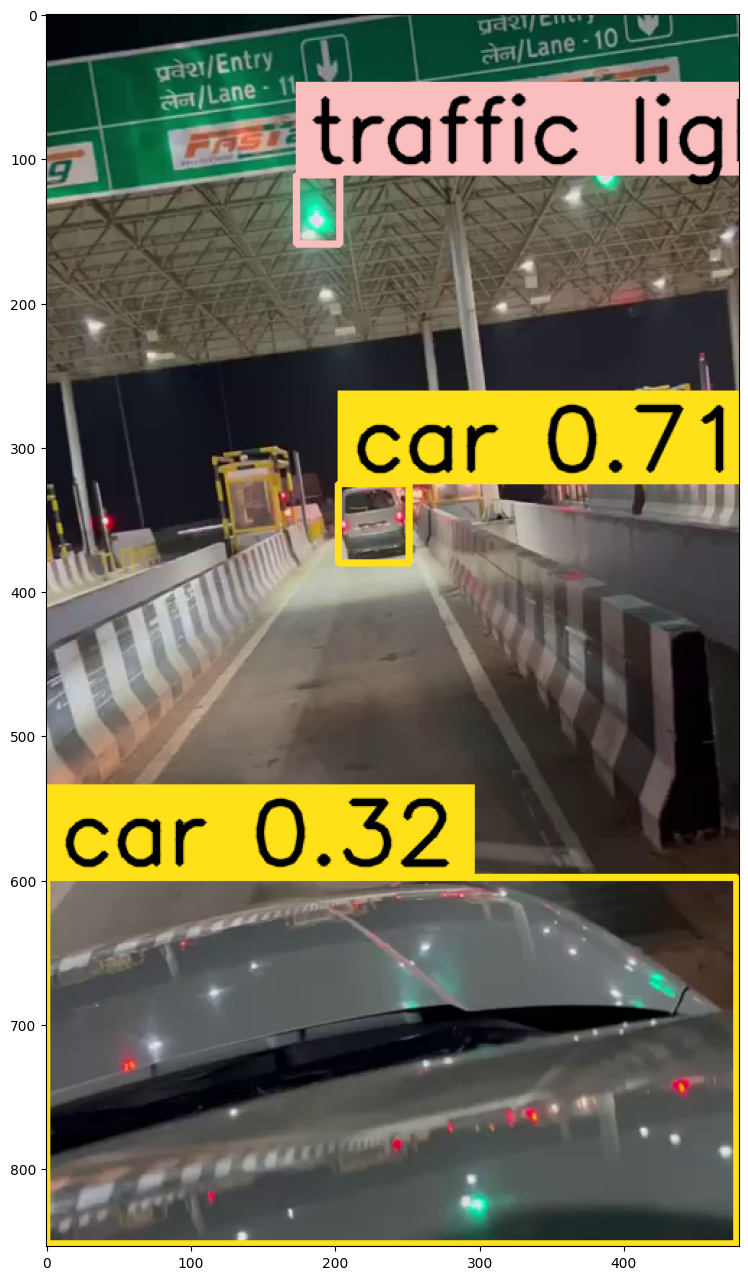

In [21]:

# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

## Predict and annotate whole video

In [23]:
# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET = f"{HOME}/counting-result.mp4"

In [24]:
VideoInfo.from_video_path(SOURCE_VIDEO)

VideoInfo(width=480, height=854, fps=29, total_frames=539)

In [25]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/539 [00:00<?, ?it/s]


0: 640x384 2 cars, 1 traffic light, 70.0ms
Speed: 6.8ms preprocess, 70.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 cars, 1 traffic light, 72.8ms
Speed: 2.6ms preprocess, 72.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 cars, 61.1ms
Speed: 7.5ms preprocess, 61.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 2 cars, 69.5ms
Speed: 14.6ms preprocess, 69.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 cars, 47.9ms
Speed: 7.6ms preprocess, 47.9ms inference, 26.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 cars, 54.2ms
Speed: 9.7ms preprocess, 54.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 cars, 53.0ms
Speed: 2.6ms preprocess, 53.0ms inference, 9.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 cars, 43.4ms
Speed: 10.1ms preprocess, 43.4ms inference, 8.4ms postproce